# Pronostico casos acumulados y diarios en Colombia de COVID-19

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [21]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from keras.models import load_model

In [22]:
colombia = pd.read_csv('colombia.csv')
colombia

,fecha reporte web,ID de caso,Casos acumulados,Recuperados,Recuperados acumulados,Fallecidos,Fallecidos acumulados
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,2,3,2,3,0,0
4,2020-03-10,0,3,0,3,0,0
...,...,...,...,...,...,...,...
727,2022-03-03,1051,6068074,556,5899871,11,138792
728,2022-03-04,1351,6069425,780,5900651,23,138815
729,2022-03-05,1191,6070616,506,5901157,7,138822
730,2022-03-06,1088,6071704,574,5901731,3,138825


In [23]:

colombia.set_index('fecha reporte web', inplace = True)
colombia_casos = colombia.drop(['Casos acumulados', 'Recuperados', 'Recuperados acumulados','Fallecidos','Fallecidos acumulados'],axis=1)
colombia_casos

,ID de caso
fecha reporte web,
2020-03-06,1
2020-03-07,0
2020-03-08,0
2020-03-09,2
2020-03-10,0
...,...
2022-03-03,1051
2022-03-04,1351
2022-03-05,1191


In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(colombia_casos)
col_scaled_cases = scaler.transform(colombia_casos)

In [25]:
n_train_data = 670
n_test_data = 60

train_scaled_col_cases = col_scaled_cases[:n_train_data]
train_scaled_col_cases

test_scaled_col_cases = col_scaled_cases[n_train_data:n_train_data+n_test_data]
test_scaled_col_cases

array([[0.45702159],
       [0.64759951],
       [0.73617045],
       [0.87615246],
       [0.86097369],
       [0.76189004],
       [0.64858331],
       [0.83924556],
       [0.85110749],
       [0.98167304],
       [1.        ],
       [0.90842141],
       [0.68228581],
       [0.81091185],
       [0.77588824],
       [0.85748819],
       [0.8724702 ],
       [0.78777828],
       [0.73327524],
       [0.59641331],
       [0.54845964],
       [0.50283899],
       [0.4964864 ],
       [0.58876771],
       [0.51860805],
       [0.45308635],
       [0.42961547],
       [0.40628514],
       [0.42472453],
       [0.38138071],
       [0.37637733],
       [0.35324376],
       [0.29106701],
       [0.25522824],
       [0.27349899],
       [0.24696425],
       [0.23246009],
       [0.15237801],
       [0.18473128],
       [0.15549809],
       [0.08888014],
       [0.10487407],
       [0.1164268 ],
       [0.11280076],
       [0.11299753],
       [0.12643355],
       [0.09503598],
       [0.081

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

window_size= 60
n_features= 1
batch_size = 1

train_generator_col = TimeseriesGenerator(train_scaled_col_cases, train_scaled_col_cases, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data of Colombia = ", len(train_scaled_col_cases))
print("Total number of samples in the generated data of Colombia = ", len(train_generator_col))

test_generator_col = TimeseriesGenerator(test_scaled_col_cases , test_scaled_col_cases , length=len(test_scaled_col_cases )-1 ,batch_size=batch_size)
print("Total number of samples in the original training data of Colombia = ", len(test_scaled_col_cases ))
print("Total number of sambles in the generated data of Colombia", len(test_generator_col))

Total number of samples in the original training data of Colombia =  670
Total number of samples in the generated data of Colombia =  610
Total number of samples in the original training data of Colombia =  60
Total number of sambles in the generated data of Colombia 1


## Red neuronal simple

In [8]:
def model_rnn_builder(hp):
  model_rnn_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_rnn_col.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='relu', input_shape=(window_size, n_features),return_sequences=True))
  model_rnn_col.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='relu'))
  model_rnn_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_rnn_col.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_rnn_col

In [9]:
tuner = kt.BayesianOptimization(model_rnn_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_rnn',
                     project_name='hp_rnn_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 38m 54s]
val_loss: nan

Best val_loss So Far: nan
Total elapsed time: 00h 38m 54s
INFO:tensorflow:Oracle triggered exit


In [10]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 512 y el learning rate mas optimo será de 0.01.



In [27]:
model_rnn_col = tuner.hypermodel.build(best_hps)
history_rnn_col = model_rnn_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 560s 907ms/step - loss: 0.1092 - root_mean_squared_error: 0.1651 - val_loss: 0.0980 - val_root_mean_squared_error: 0.1274 - lr: 0.0100
Epoch 2/100
610/610 [==============================] - 550s 901ms/step - loss: 0.0908 - root_mean_squared_error: 0.0951 - val_loss: 0.0847 - val_root_mean_squared_error: 0.0548 - lr: 0.0100
Epoch 3/100
610/610 [==============================] - 497s 814ms/step - loss: 0.0874 - root_mean_squared_error: 0.0763 - val_loss: 0.0830 - val_root_mean_squared_error: 0.0392 - lr: 0.0100
Epoch 4/100
610/610 [==============================] - 467s 765ms/step - loss: 0.0869 - root_mean_squared_error: 0.0741 - val_loss: 0.0851 - val_root_mean_squared_error: 0.0618 - lr: 0.0100
Epoch 5/100
610/610 [==============================] - 468s 767ms/step - loss: 0.0864 - root_mean_squared_error: 0.0724 - val_loss: 0.0816 - val_root_mean_squared_error: 0.0227 - lr: 0.0100
Epoch 6/100
610/610 [=============================

In [28]:
model_rnn_col.save("model_rnn.h5")

Best epoch: 1


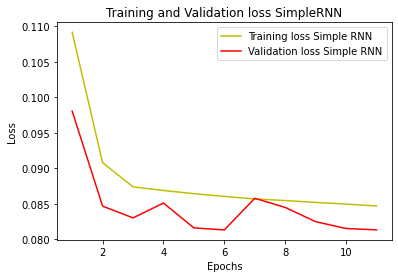

In [29]:
val_acc_per_epoch = history_rnn_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_rnn_col = history_rnn_col.history['loss']
val_loss_rnn_col = history_rnn_col.history['val_loss']
epochs = range(1,len(loss_rnn_col)+1)

plt.plot(epochs, loss_rnn_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_rnn_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model_rnn_col = load_model('model_rnn.h5')

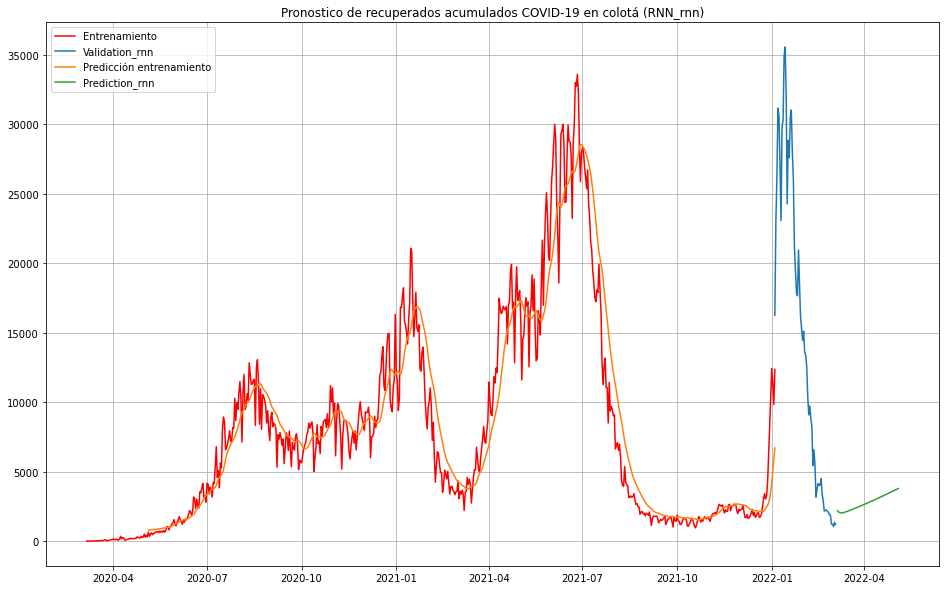

In [31]:
predictions_rnn_col = []

first_batch = test_scaled_col_cases[-window_size:]
current_batch_rnn_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_rnn_col = model_rnn_col.predict(current_batch_rnn_col)[0]
    

    predictions_rnn_col.append(current_pred_rnn_col)
    
    
    current_batch_rmv_first_rnn_col= current_batch_rnn_col[:,1:,:]
 

    current_batch_rnn_col= np.append(current_batch_rmv_first_rnn_col,[[current_pred_rnn_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_cases)
dates_train_data_rnn_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_rnn_col = pd.DataFrame({'Date':dates_train_data_rnn_col,'train':train_data_actual_scale[:,0]})
df_train_rnn_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_rnn_col = model_rnn_col.predict(train_generator_col)
train_prediction_data_actual_scale_rnn_col =scaler.inverse_transform(train_prediction_rnn_col)
dates_predict_train_data_rnn_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_rnn_col = pd.DataFrame({'Date':dates_predict_train_data_rnn_col,'train':train_prediction_data_actual_scale_rnn_col[:,0]})
df_predict_train_rnn_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_rnn_col = scaler.inverse_transform(test_scaled_col_cases)
dates_test_data_rnn_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_rnn_col = pd.DataFrame({'Date':dates_test_data_rnn_col,'Test_rnn_col':test_data_actual_scale_rnn_col[:,0]})
df_test_rnn_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_rnn_col = scaler.inverse_transform(predictions_rnn_col)
dates_predictions_rnn_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_rnn_col  = pd.DataFrame({'Date':dates_predictions_rnn_col,'Predictions_rnn_col':predictions_actual_scale_rnn_col[:,0]})
df_predictions_rnn_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_col,'r', label='Entrenamiento')
plt.plot(df_test_rnn_col['Test_rnn_col'], label='Validation_rnn')
plt.plot(df_predict_train_rnn_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN_rnn)')
plt.plot(df_predictions_rnn_col ['Predictions_rnn_col'], label='Prediction_rnn')
plt.grid()
plt.legend()

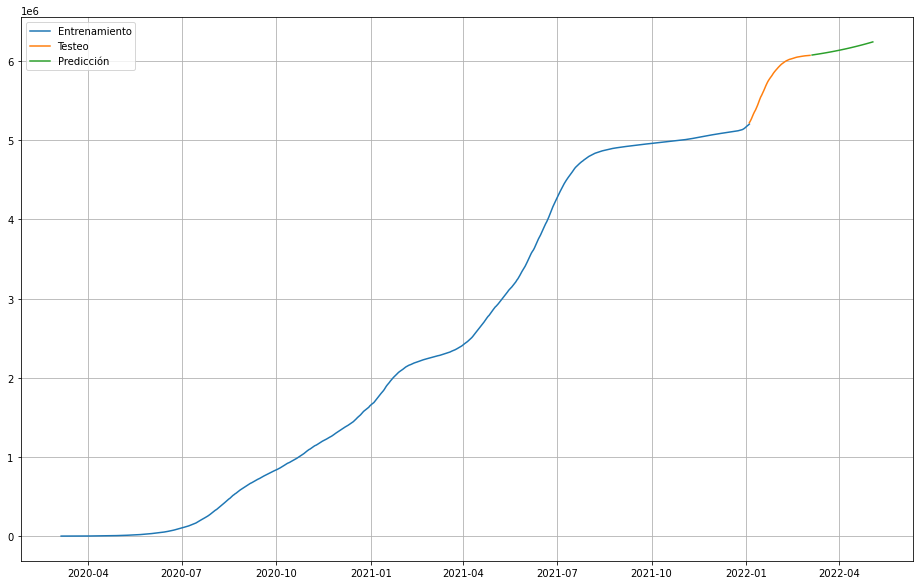

In [32]:
# Creación columna con casos acumulados.
df_predictions_rnn_col['acumulados']= df_predictions_rnn_col['Predictions_rnn_col'].cumsum()
df_predictions_rnn_col['acumulados'] = [i+colombia['Casos acumulados'].max() for i in df_predictions_rnn_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_rnn_col['acumulados']=df_train_rnn_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_rnn_col['acumulados']=df_test_rnn_col['Test_rnn_col'].cumsum()
df_test_rnn_col['acumulados'] = [i+df_train_rnn_col['acumulados'].max() for i in df_test_rnn_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_rnn_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_rnn_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [33]:
df_predictions_rnn_col

,Predictions_rnn_col,acumulados
Date,,
2022-03-06,2188.473666,6.074844e+06
2022-03-07,2096.855964,6.076941e+06
2022-03-08,2050.086197,6.078991e+06
2022-03-09,2031.517289,6.081023e+06
2022-03-10,2030.552994,6.083053e+06
2022-03-11,2040.665899,6.085094e+06
2022-03-12,2057.770075,6.087152e+06
2022-03-13,2079.304760,6.089231e+06
2022-03-14,2103.692306,6.091335e+06


## Red neuronal con celdas LSTM

In [34]:
def model_lstm_builder(hp):
  model_lstm_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=50, max_value=400, step=50)
  model_lstm_col.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='relu', input_shape=(window_size, n_features),return_sequences=True))
  model_lstm_col.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='relu'))
  model_lstm_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_lstm_col.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_lstm_col

In [35]:
tuner = kt.BayesianOptimization(model_lstm_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_lstm',
                     project_name='hp_lstm_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 15m 34s]
val_loss: 0.0320376418530941

Best val_loss So Far: 0.0091010220348835
Total elapsed time: 00h 42m 30s
INFO:tensorflow:Oracle triggered exit


In [36]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 50 y el learning rate mas optimo será de 0.01.



In [37]:
model_lstm_col = tuner.hypermodel.build(best_hps)
history_lstm_col = model_lstm_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)


Epoch 1/100
610/610 [==============================] - 24s 35ms/step - loss: 0.0280 - root_mean_squared_error: 0.1408 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0924 - lr: 0.0100
Epoch 2/100
610/610 [==============================] - 21s 34ms/step - loss: 0.0150 - root_mean_squared_error: 0.0827 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0762 - lr: 0.0100
Epoch 3/100
610/610 [==============================] - 21s 34ms/step - loss: 0.0143 - root_mean_squared_error: 0.0783 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0211 - lr: 0.0100
Epoch 4/100
610/610 [==============================] - 21s 34ms/step - loss: 0.0139 - root_mean_squared_error: 0.0761 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0365 - lr: 0.0100
Epoch 5/100
610/610 [==============================] - 21s 34ms/step - loss: 0.0136 - root_mean_squared_error: 0.0743 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0457 - lr: 0.0100
Epoch 6/100
610/610 [==============================] - 21s 3

In [38]:
model_lstm_col.save("model_lstm.h5")

Best epoch: 1


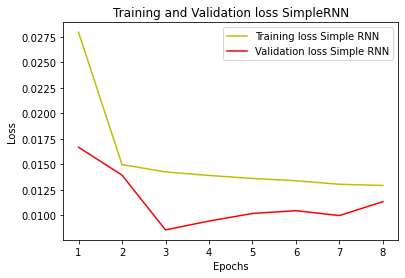

In [39]:
val_acc_per_epoch = history_lstm_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_lstm_col = history_lstm_col.history['loss']
val_loss_lstm_col = history_lstm_col.history['val_loss']
epochs = range(1,len(loss_lstm_col)+1)

plt.plot(epochs, loss_lstm_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_lstm_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
model_lstm_col = load_model('model_lstm.h5')

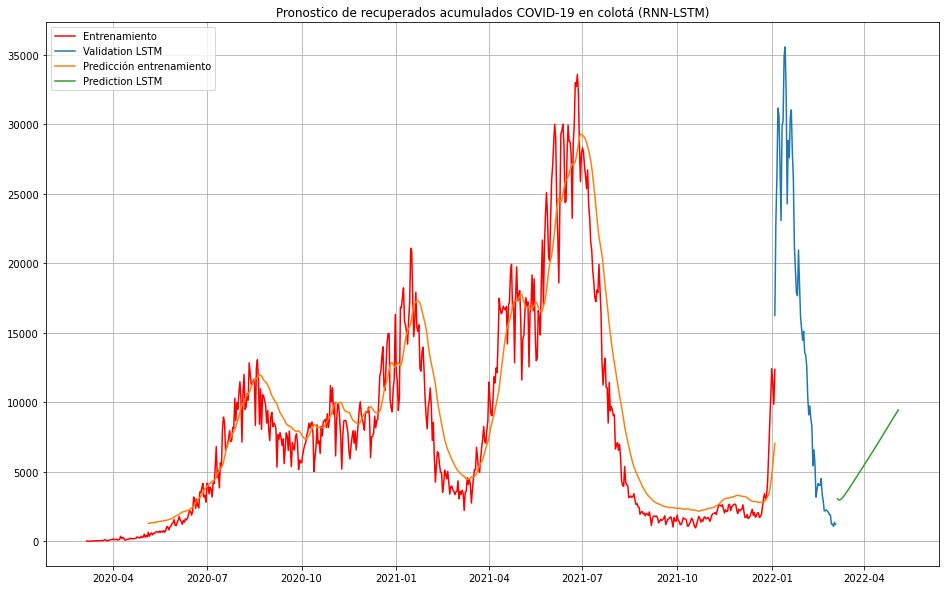

In [41]:
predictions_lstm_col = []

first_batch = test_scaled_col_cases[-window_size:]
current_batch_lstm_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_lstm_col = model_lstm_col.predict(current_batch_lstm_col)[0]
    

    predictions_lstm_col.append(current_pred_lstm_col)
    
    
    current_batch_rmv_first_lstm_col= current_batch_lstm_col[:,1:,:]
 

    current_batch_lstm_col= np.append(current_batch_rmv_first_lstm_col,[[current_pred_lstm_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_cases)
dates_train_data_lstm_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_lstm_col = pd.DataFrame({'Date':dates_train_data_lstm_col,'train':train_data_actual_scale[:,0]})
df_train_lstm_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_lstm_col = model_lstm_col.predict(train_generator_col)
train_prediction_data_actual_scale_lstm_col =scaler.inverse_transform(train_prediction_lstm_col)
dates_predict_train_data_lstm_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_lstm_col = pd.DataFrame({'Date':dates_predict_train_data_lstm_col,'train':train_prediction_data_actual_scale_lstm_col[:,0]})
df_predict_train_lstm_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_lstm_col = scaler.inverse_transform(test_scaled_col_cases)
dates_test_data_lstm_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_lstm_col = pd.DataFrame({'Date':dates_test_data_lstm_col,'Test_LSTM_col':test_data_actual_scale_lstm_col[:,0]})
df_test_lstm_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_lstm_col = scaler.inverse_transform(predictions_lstm_col)
dates_predictions_lstm_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_lstm_col  = pd.DataFrame({'Date':dates_predictions_lstm_col,'Predictions_LSTM_col':predictions_actual_scale_lstm_col[:,0]})
df_predictions_lstm_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_col,'r', label='Entrenamiento')
plt.plot(df_test_lstm_col['Test_LSTM_col'], label='Validation LSTM')
plt.plot(df_predict_train_lstm_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN-LSTM)')
plt.plot(df_predictions_lstm_col ['Predictions_LSTM_col'], label='Prediction LSTM')
plt.grid()
plt.legend()

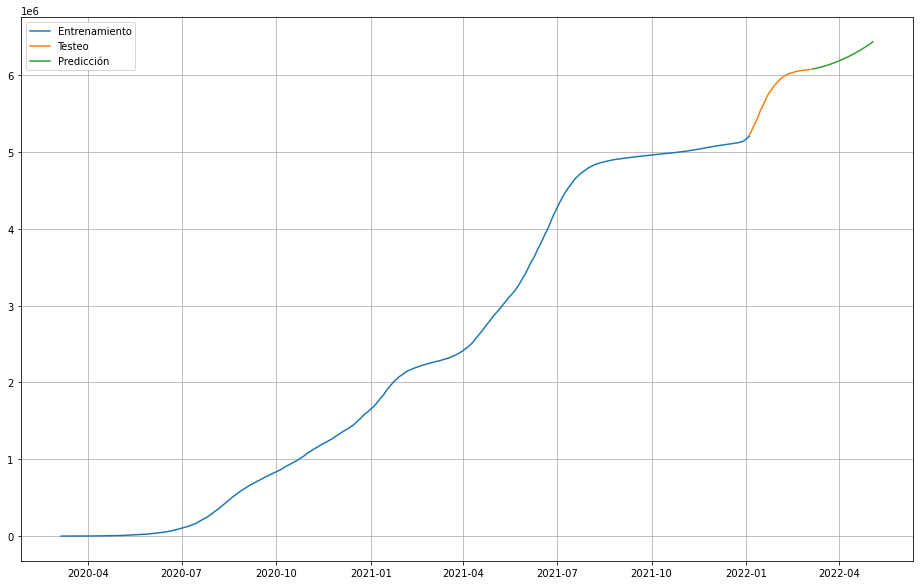

In [42]:
# Creación columna con casos acumulados.
df_predictions_lstm_col['acumulados']= df_predictions_lstm_col['Predictions_LSTM_col'].cumsum()
df_predictions_lstm_col['acumulados'] = [i+colombia['Casos acumulados'].max() for i in df_predictions_lstm_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_lstm_col['acumulados']=df_train_lstm_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_lstm_col['acumulados']=df_test_lstm_col['Test_LSTM_col'].cumsum()
df_test_lstm_col['acumulados'] = [i+df_train_lstm_col['acumulados'].max() for i in df_test_lstm_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_lstm_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_lstm_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [43]:
df_predictions_lstm_col

,Predictions_LSTM_col,acumulados
Date,,
2022-03-06,3044.826496,6.075701e+06
2022-03-07,2968.836973,6.078670e+06
2022-03-08,2961.890232,6.081632e+06
2022-03-09,2998.530262,6.084630e+06
2022-03-10,3062.724003,6.087693e+06
2022-03-11,3144.381609,6.090837e+06
2022-03-12,3237.165981,6.094074e+06
2022-03-13,3337.089529,6.097411e+06
2022-03-14,3441.645564,6.100853e+06


## Red neuronal con celdas GRU

In [44]:
def model_gru_builder(hp):
  model_gru_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_gru_col.add(GRU(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='tanh', input_shape=(window_size, n_features),return_sequences=True))
  model_gru_col.add(GRU(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='tanh'))
  model_gru_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_gru_col.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_gru_col

In [45]:
tuner = kt.BayesianOptimization(model_gru_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_gru',
                     project_name='hp_gru_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 04m 10s]
val_loss: 0.0016619631787762046

Best val_loss So Far: 0.00036607732181437314
Total elapsed time: 00h 42m 35s
INFO:tensorflow:Oracle triggered exit


In [46]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 32 y el learning rate mas optimo será de 0.01.



In [47]:
model_gru_col = tuner.hypermodel.build(best_hps)
history_gru_col = model_gru_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 35s 50ms/step - loss: 0.0933 - root_mean_squared_error: 0.3050 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0474 - lr: 0.0100
Epoch 2/100
610/610 [==============================] - 30s 49ms/step - loss: 0.0065 - root_mean_squared_error: 0.0700 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0420 - lr: 0.0100
Epoch 3/100
610/610 [==============================] - 30s 49ms/step - loss: 0.0040 - root_mean_squared_error: 0.0562 - val_loss: 7.4551e-04 - val_root_mean_squared_error: 0.0074 - lr: 0.0100
Epoch 4/100
610/610 [==============================] - 30s 49ms/step - loss: 0.0049 - root_mean_squared_error: 0.0643 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0235 - lr: 0.0100
Epoch 5/100
610/610 [==============================] - 30s 49ms/step - loss: 0.0037 - root_mean_squared_error: 0.0557 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0265 - lr: 0.0100
Epoch 6/100
610/610 [==============================] - 2

In [48]:
model_gru_col.save("model_gru.h5")


Best epoch: 1


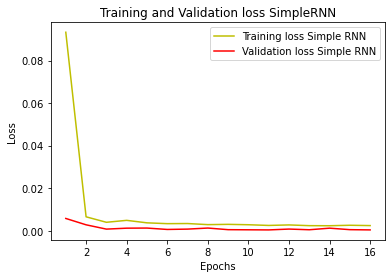

In [49]:
val_acc_per_epoch = history_gru_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_gru_col = history_gru_col.history['loss']
val_loss_gru_col = history_gru_col.history['val_loss']
epochs = range(1,len(loss_gru_col)+1)

plt.plot(epochs, loss_gru_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_gru_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
model_gru_col = load_model('model_gru.h5')

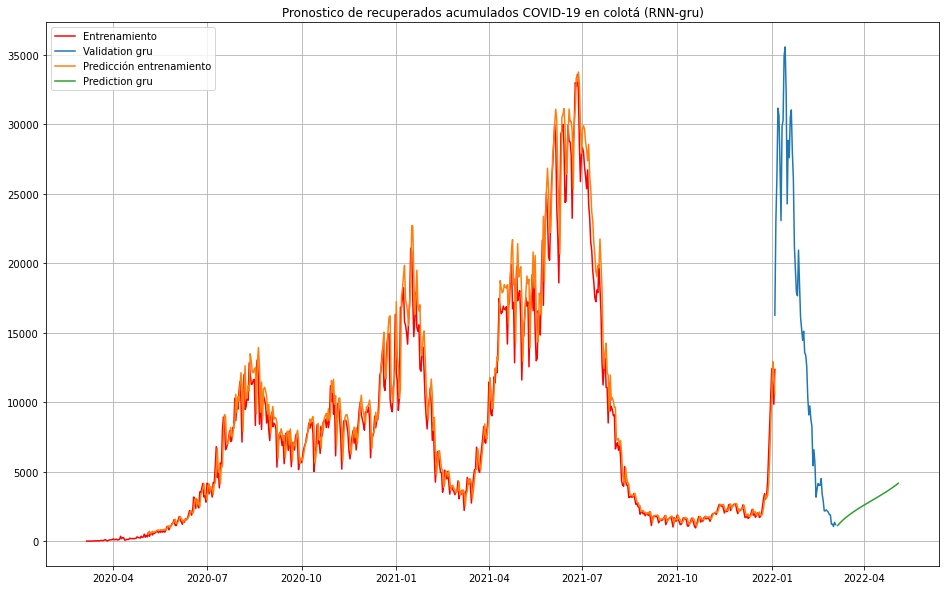

In [51]:
predictions_gru_col = []

first_batch = col_scaled_cases[-window_size:]
current_batch_gru_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_gru_col = model_gru_col.predict(current_batch_gru_col)[0]
    

    predictions_gru_col.append(current_pred_gru_col)
    
    
    current_batch_rmv_first_gru_col= current_batch_gru_col[:,1:,:]
 

    current_batch_gru_col= np.append(current_batch_rmv_first_gru_col,[[current_pred_gru_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_cases)
dates_train_data_gru_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_gru_col = pd.DataFrame({'Date':dates_train_data_gru_col,'train':train_data_actual_scale[:,0]})
df_train_gru_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_gru_col = model_gru_col.predict(train_generator_col)
train_prediction_data_actual_scale_gru_col =scaler.inverse_transform(train_prediction_gru_col)
dates_predict_train_data_gru_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_gru_col = pd.DataFrame({'Date':dates_predict_train_data_gru_col,'train':train_prediction_data_actual_scale_gru_col[:,0]})
df_predict_train_gru_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_gru_col = scaler.inverse_transform(test_scaled_col_cases)
dates_test_data_gru_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_gru_col = pd.DataFrame({'Date':dates_test_data_gru_col,'Test_gru_col':test_data_actual_scale_gru_col[:,0]})
df_test_gru_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_gru_col = scaler.inverse_transform(predictions_gru_col)
dates_predictions_gru_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_gru_col = pd.DataFrame({'Date':dates_predictions_gru_col,'Predictions_gru_col':predictions_actual_scale_gru_col[:,0]})
df_predictions_gru_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_gru_col,'r', label='Entrenamiento')
plt.plot(df_test_gru_col['Test_gru_col'], label='Validation gru')
plt.plot(df_predict_train_gru_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN-gru)')
plt.plot(df_predictions_gru_col ['Predictions_gru_col'], label='Prediction gru')
plt.grid()
plt.legend()

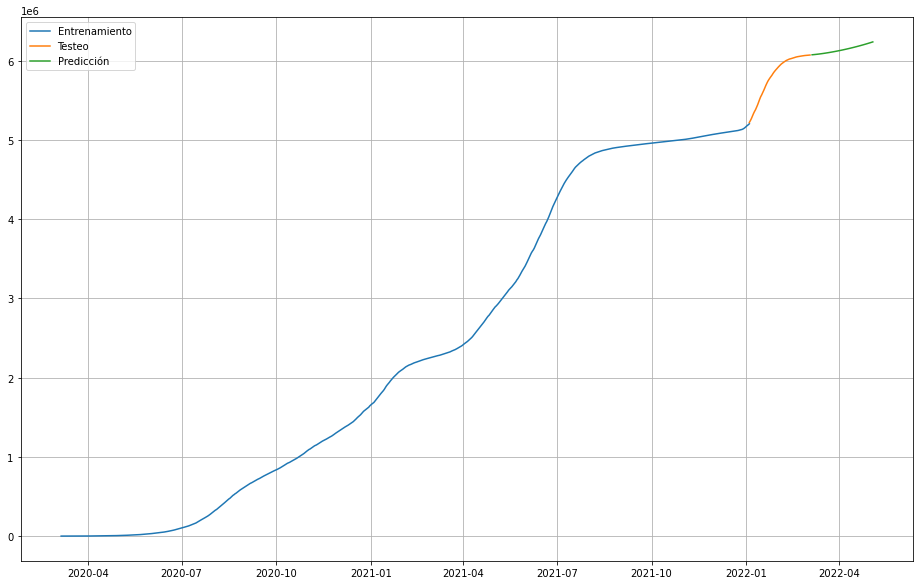

In [52]:
# Creación columna con casos acumulados.
df_predictions_gru_col['acumulados']= df_predictions_gru_col['Predictions_gru_col'].cumsum()
df_predictions_gru_col['acumulados'] = [i+colombia['Casos acumulados'].max() for i in df_predictions_gru_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_gru_col['acumulados']=df_train_gru_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_gru_col['acumulados']=df_test_gru_col['Test_gru_col'].cumsum()
df_test_gru_col['acumulados'] = [i+df_train_gru_col['acumulados'].max() for i in df_test_gru_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_gru_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_gru_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_gru_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [53]:
df_predictions_gru_col

,Predictions_gru_col,acumulados
Date,,
2022-03-06,1110.960116,6.073767e+06
2022-03-07,1199.250099,6.074966e+06
2022-03-08,1281.181779,6.076247e+06
2022-03-09,1358.397478,6.077606e+06
2022-03-10,1431.415658,6.079037e+06
2022-03-11,1500.946684,6.080538e+06
2022-03-12,1567.505836,6.082106e+06
2022-03-13,1631.511913,6.083737e+06
2022-03-14,1693.287229,6.085430e+06
